# Land ice Investigations

Let's start by importing modules

In [1]:
# Homemade models
from modules import week8 as w8
from modules import week5 as w5
from modules import week9 as w9
from modules import week10 as w10
from modules import misc

# Calculations and data stuff
import numpy as np
import xarray as xr
from pyproj import Proj, transform

# Better loops
import itertools

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm, LogNorm

%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
table {float:left}
</style>

Now we want to check we have the right data. 
## Data we want
The statuses go as follows:

    Not downloaded -> Downloaded -> Processed -> Loaded

| Variable        	| Source 	| Status     	|
|-----------------	|--------	|------------	|
| Land Ice        	| GRACE  	| Loaded     	|
| Ice Velocity    	| NSIDC  	| Downloaded 	|
| LW radiation    	| ERA5   	| Loaded     	|
| SW radiation    	| ERA5   	| Loaded     	|
| Cloud Variables 	| ERA5   	| Loaded     	|
| Temperature     	| ERA5   	| Loaded     	|
| Ozone           	| ERA5   	| Loaded     	|

Some of the variables need reprojecting, specifically the ones from the ERA5 dataset. let's do that here.

In [3]:
# # Cloud Cover
# clouds = xr.open_dataset('data/ERA5/clouds.nc')
# cc = clouds.cc.sel(level=700).sel(expver=1)
# w10.process_data(cc, variable = 'cc_700')
# cc = clouds.cc.sel(level=500).sel(expver=1)
# w10.process_data(cc, variable = 'cc_500')
# cc = clouds.cc.sel(level=200).sel(expver=1)
# w10.process_data(cc, variable = 'cc_200')

# # Ozone
# ozone = xr.open_dataset('data/ERA5/ozone_mass_mixing_ratio.nc')
# o3 = ozone.o3.sel(level=700).sel(expver=1)
# w10.process_data(o3, variable = 'o3_700')
# o3 = ozone.o3.sel(level=500).sel(expver=1)
# w10.process_data(o3, variable = 'o3_500')
# o3 = ozone.o3.sel(level=200).sel(expver=1)
# w10.process_data(o3, variable = 'o3_200')

# ozone = xr.open_dataset('data/ERA5/ozone_mass_mixing_ratio_50_100.nc')
# o3 = ozone.o3.sel(level=50).sel(expver=1)
# w10.process_data(o3, variable = 'o3_50')
# o3 = ozone.o3.sel(level=100).sel(expver=1)
# w10.process_data(o3, variable = 'o3_100')

# Wind Velocities
# winds = xr.open_dataset('data/ERA5/windspeed.nc')
# u = winds.u.sel(level=700).sel(expver=1)
# w10.process_data(u, variable = 'u_700')
# u = winds.u.sel(level=500).sel(expver=1)
# w10.process_data(u, variable = 'u_500')
# u = winds.u.sel(level=200).sel(expver=1)
# w10.process_data(u, variable = 'u_200')
# v = winds.v.sel(level=700).sel(expver=1)
# w10.process_data(v, variable = 'v_700')
# v = winds.v.sel(level=500).sel(expver=1)
# w10.process_data(v, variable = 'v_500')
# v = winds.v.sel(level=200).sel(expver=1)
# w10.process_data(v, variable = 'v_200')


# # Radiation
# surface_net_solar_radiation = xr.open_dataset('data/ERA5/surface_net_solar_radiation.nc')
# surface_solar_radiation_downwards = xr.open_dataset('data/ERA5/surface_solar_radiation_downwards.nc')
# ssr = surface_net_solar_radiation.ssr.sel(expver=1)
# ssrd = surface_solar_radiation_downwards.ssrd.sel(expver=1)
# ssru = ssr-ssrd
# w10.process_data(ssr, variable = 'ssr')
# w10.process_data(ssr, variable = 'ssrd')
# w10.process_data(ssr, variable = 'ssru')


# # precipitation
# precipitation = xr.open_dataarray('data/ERA5/precipitation.nc')
# # precipitation
# w10.process_data(precipitation, variable = 'tp')


# # geopotential
# geopotential = xr.open_dataset('data/ERA5/geopotential2.nc')
# z = geopotential.z.sel(level=700).sel(expver=1)
# w10.process_data(z, variable = 'z_700')
# z = geopotential.z.sel(level=500).sel(expver=1)
# w10.process_data(z, variable = 'z_500')
# z = geopotential.z.sel(level=200).sel(expver=1)
# w10.process_data(z, variable = 'z_200')

----------------------------------------------------------------------------------------------------------------------
                                                  Processing z_700                                                   
----------------------------------------------------------------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:47<00:00, 10.66it/s]


z_700 processed
----------------------------------------------------------------------------------------------------------------------
                                                  Processing z_500                                                   
----------------------------------------------------------------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:47<00:00, 10.72it/s]


z_500 processed
----------------------------------------------------------------------------------------------------------------------
                                                  Processing z_200                                                   
----------------------------------------------------------------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:46<00:00, 10.89it/s]


z_200 processed


In [4]:
# Loading data from file
SIC, LIC = w8.load_ice_data()
SIC = SIC.sel(time=slice('1979-01-01','2019-12-31')).compute().pipe(w5.yearly_average)
LIC = LIC.sel(time=slice('1979-01-01','2019-12-31')).compute().pipe(w5.yearly_average)
temperature = w8.load_temp_data().sel(time=slice('1979-01-01','2019-12-31')).compute().pipe(w5.yearly_average)

# Landmask
landmask = w8.load_landmask()
landmask = landmask >= .5

# New variables
cc_700 = xr.open_dataarray('processed_data/cc_700.nc').pipe(w5.yearly_average)
cc_500 = xr.open_dataarray('processed_data/cc_500.nc').pipe(w5.yearly_average)
cc_200 = xr.open_dataarray('processed_data/cc_200.nc').pipe(w5.yearly_average)
o3_700 = xr.open_dataarray('processed_data/o3_700.nc').pipe(w5.yearly_average)
o3_500 = xr.open_dataarray('processed_data/o3_500.nc').pipe(w5.yearly_average)
o3_200 = xr.open_dataarray('processed_data/o3_200.nc').pipe(w5.yearly_average)
o3_100 = xr.open_dataarray('processed_data/o3_100.nc').pipe(w5.yearly_average)
o3_50 = xr.open_dataarray('processed_data/o3_50.nc').pipe(w5.yearly_average)
u_700 = xr.open_dataarray('processed_data/u_700.nc').pipe(w5.yearly_average)
u_500 = xr.open_dataarray('processed_data/u_500.nc').pipe(w5.yearly_average)
u_200 = xr.open_dataarray('processed_data/u_200.nc').pipe(w5.yearly_average)
v_700 = xr.open_dataarray('processed_data/v_700.nc').pipe(w5.yearly_average)
v_500 = xr.open_dataarray('processed_data/v_500.nc').pipe(w5.yearly_average)
v_200 = xr.open_dataarray('processed_data/v_200.nc').pipe(w5.yearly_average)
ssrd = xr.open_dataarray('processed_data/ssrd.nc').pipe(w5.yearly_average)
ssru = xr.open_dataarray('processed_data/ssru.nc').pipe(w5.yearly_average)
ssr = xr.open_dataarray('processed_data/ssr.nc').pipe(w5.yearly_average)
tp = xr.open_dataarray('processed_data/tp.nc').pipe(w5.yearly_average)
z_700 = xr.open_dataarray('processed_data/z_700.nc').pipe(w5.yearly_average)
z_500 = xr.open_dataarray('processed_data/z_500.nc').pipe(w5.yearly_average)
z_200 = xr.open_dataarray('processed_data/z_200.nc').pipe(w5.yearly_average)

data = xr.Dataset()
data['SIC'] = SIC
data['LIC'] = LIC
data['landmask'] = landmask
data['cc_700'] = cc_700
data['cc_500'] = cc_500
data['cc_200'] = cc_200
data['o3_700'] = o3_700
data['o3_500'] = o3_500
data['o3_200'] = o3_200
data['u_700'] = u_700
data['u_500'] = u_500
data['u_200'] = u_200
data['v_700'] = v_700
data['v_500'] = v_500
data['v_200'] = v_200
data['o3_100'] = o3_100
data['o3_50'] = o3_50
data['ssrd'] = ssrd
data['ssru'] = ssru
data['ssr'] = ssr
data['skt'] = temperature.skt
data['tp'] = tp
data['z_700'] = z_700
data['z_500'] = z_500
data['z_200'] = z_200

data['LIC'] = data.LIC.where(landmask)

attrs = {v:data[v].attrs for v in data}

misc.print_heading("Data Loaded")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:04<00:00, 45.26it/s]


----------------------------------------------------------------------------------------------------------------------
                                                     Data Loaded                                                     
----------------------------------------------------------------------------------------------------------------------


In [5]:
data_annually_averaged = (data.pipe(w5.yearly_average)).copy()
data_anomalous = (data.pipe(w5.find_anomalies).pipe(w5.yearly_average)).copy()
data_short = data_anomalous.sel(time=slice('2002-01-01', '2019-12-31')).copy()
data_long = data_anomalous.sel(time=slice('1979-01-01', '2019-12-31')).copy()

for variable, attributes in attrs.items():
    data[variable].attrs = attributes
    data_anomalous[variable].attrs = attributes
    data_short[variable].attrs = attributes
    data_long[variable].attrs = attributes

misc.print_heading("Preprocessing Done")
data_short

----------------------------------------------------------------------------------------------------------------------
                                                 Preprocessing Done                                                  
----------------------------------------------------------------------------------------------------------------------


<xarray.Dataset>
Dimensions:   (time: 18, x: 316, y: 332)
Coordinates:
  * time      (time) datetime64[ns] 2002-01-01 2003-01-01 ... 2019-01-01
  * y         (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x         (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
    month     int64 1
Data variables:
    SIC       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LIC       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    landmask  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cc_700    (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cc_500    (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cc_200    (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    o3_700    (time, y, x) float64 0.0 0.0 0.0 ... 8.851e-09 8.846e-09 8.831e-09
    o3_500    (time, y, x) float64 0.0 0.0 0.0 ... 1.219e-08 1.228e-08 1.238e-08
    o3_200    (time, y, x) float64 0.0 0.0 0.0 ... 8.843e-09 8.243e-09 7.688e-09
    u_700     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    u_500     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    u_200     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v_700     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v_500     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v_200     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    o3_100    (time, y, x) float64 0.0 0.0 0.0 ... -5.384e-08 -5.459e-08
    o3_50     (time, y, x) float64 0.0 0.0 0.0 ... 1.547e-07 1.535e-07 1.523e-07
    ssrd      (time, y, x) float64 0.0 0.0 0.0 ... -9.367e+04 -7.588e+04
    ssru      (time, y, x) float64 0.0 0.0 0.0 ... -9.367e+04 -7.588e+04
    ssr       (time, y, x) float64 0.0 0.0 0.0 ... -9.367e+04 -7.588e+04
    skt       (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4128 -0.427 -0.4652
    tp        (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    z_700     (time, y, x) float64 0.0 0.0 0.0 0.0 ... 8.975 14.31 19.77 25.13
    z_500     (time, y, x) float64 0.0 0.0 0.0 0.0 ... 32.07 38.96 45.75 52.84
    z_200     (time, y, x) float64 0.0 0.0 0.0 0.0 ... 168.0 174.4 181.2 187.5

Now we want to plot the distribution for the different variables individually and together

In [6]:
def plot_mean_spatial_distribution(data, name):
    data_mean = data.mean(dim='time')
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
    vmax = max(-data_mean.min(),data_mean.max())
    vmin = -vmax
    divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    contour = plt.contourf(data_mean.x, data_mean.y, data_mean.values, cmap = 'RdBu_r', norm = divnorm, transform = ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.set_title(f'Mean {name} from 1979 to 2019')
    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.93, 0.2, 0.05, 0.6])
    cbar = fig.colorbar(contour, cax=cbar_ax, shrink=0.88)
    if data.attrs != {}:
        cbar.ax.set_ylabel(f'{data.attrs["long_name"]} [{data.attrs["units"]}]')
    misc.savefigures(folder=f'images/2021w4/mean_spatial_plots',
                     filename=f'{data.name}')
    plt.show()

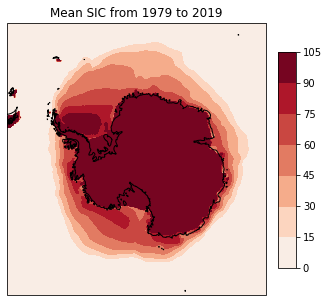

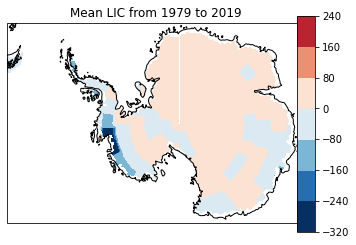

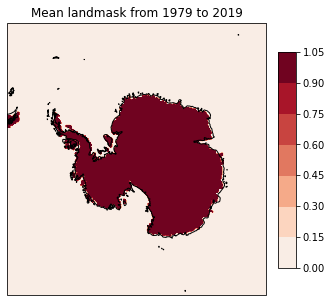

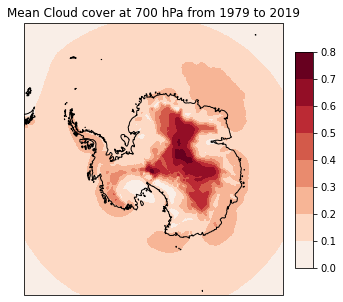

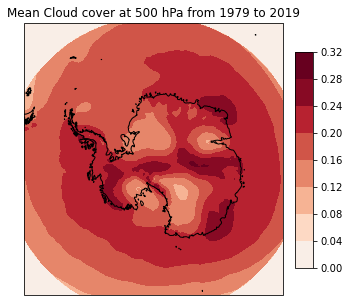

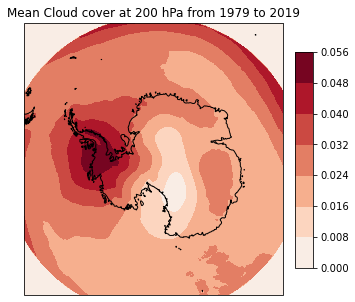

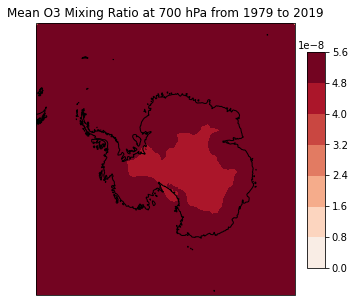

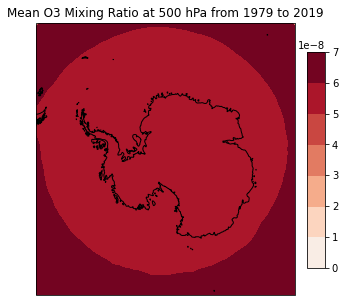

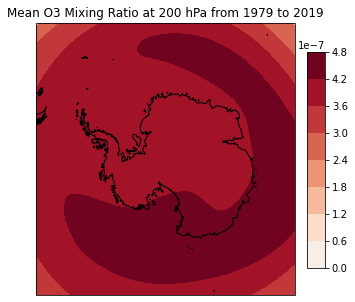

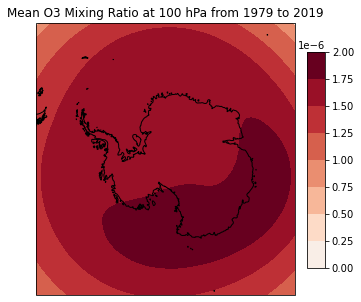

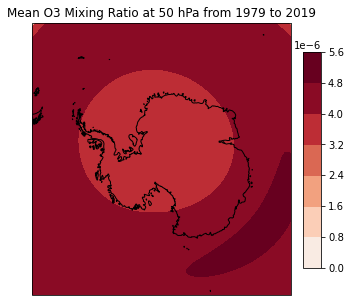

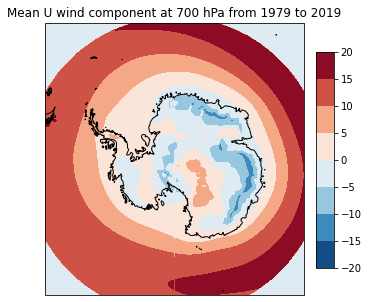

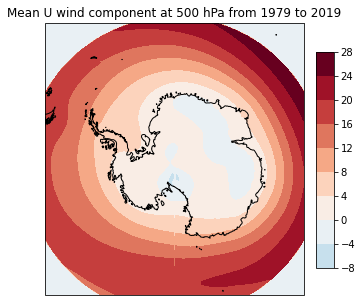

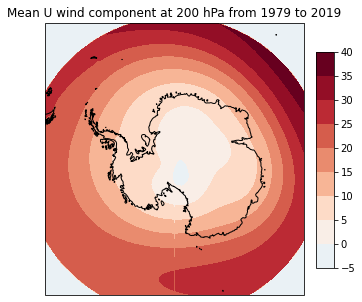

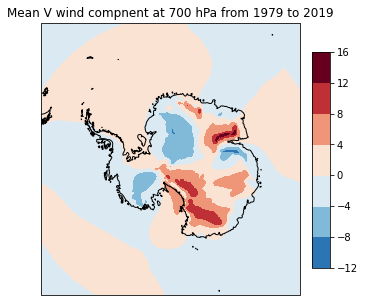

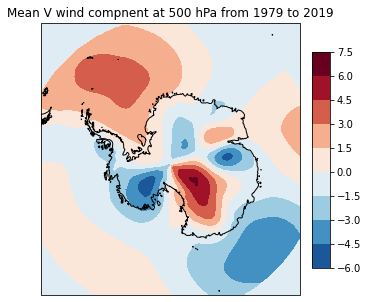

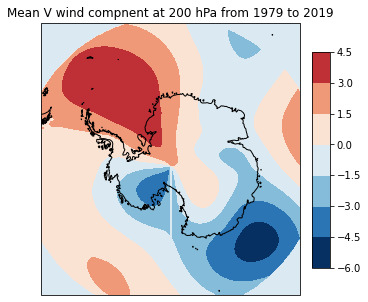

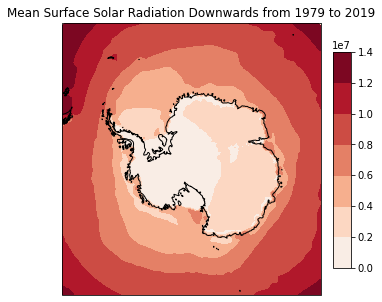

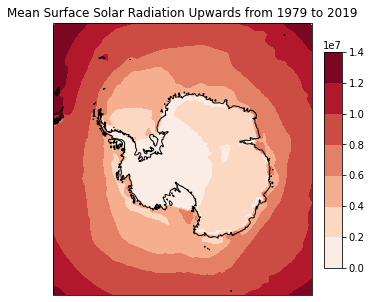

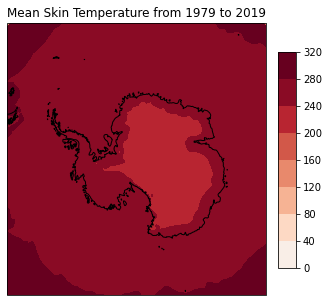

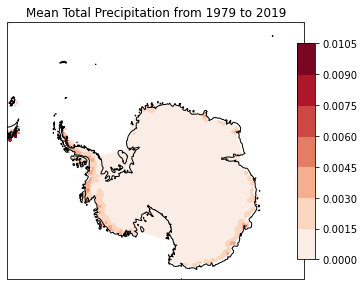

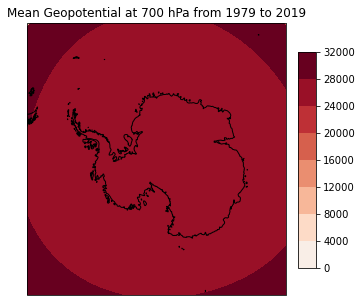

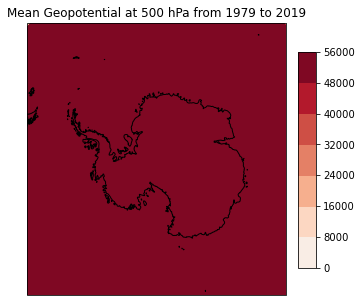

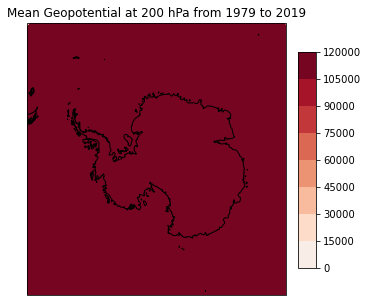

In [7]:
namedict = {'SIC'     : 'SIC',
            'LIC'     : 'LIC',
            'landmask': 'landmask',
            'cc_700'  : 'Cloud cover at 700 hPa',
            'cc_500'  : 'Cloud cover at 500 hPa',
            'cc_200'  : 'Cloud cover at 200 hPa',
            'o3_700'  : 'O3 Mixing Ratio at 700 hPa',
            'o3_500'  : 'O3 Mixing Ratio at 500 hPa',
            'o3_200'  : 'O3 Mixing Ratio at 200 hPa',
            'o3_100'  : 'O3 Mixing Ratio at 100 hPa',
            'o3_50'   : 'O3 Mixing Ratio at 50 hPa',
            'u_700'   : 'U wind component at 700 hPa',
            'u_500'   : 'U wind component at 500 hPa',
            'u_200'   : 'U wind component at 200 hPa',
            'v_700'   : 'V wind compnent at 700 hPa',
            'v_500'   : 'V wind compnent at 500 hPa',
            'v_200'   : 'V wind compnent at 200 hPa',
            'ssrd'    : 'Surface Solar Radiation Downwards',
            'ssru'    : 'Surface Solar Radiation Upwards',
            'skt'     : 'Skin Temperature',
            'tp'      : 'Total Precipitation',
            'z_700'   : 'Geopotential at 700 hPa',
            'z_500'   : 'Geopotential at 500 hPa',
            'z_200'   : 'Geopotential at 200 hPa',}
for variable, name in namedict.items():
    plot_mean_spatial_distribution(data_annually_averaged[variable], name)

# Correlations

Before doing any complex analysis let's calculate the correlation between each variable and the land ice for each gridpoint.

In [8]:
variables = ['cc_700','cc_500','cc_200','o3_700','o3_500','o3_200', 'o3_100','o3_50','ssrd','ssru','skt','u_700','u_500','u_200','v_700','v_500','v_200', 'tp', 'z_700', 'z_500', 'z_200']
# for variable in variables:
#     w10.plot_scatter(data_annually_averaged.copy(), independent=variable, dependant='LIC', landmask=True, filename = f'LIC_and_{variable}')
# #     w10.plot_scatter(data_anomalous.copy(), independent=variable, dependant='LIC', landmask=True, filename = f'LIC_and_{variable}_anomalous')

In [9]:
correlations_dict = {}
for variable in variables:
    subdata = data_annually_averaged.sel(time=slice('2002-01-01', '2019-12-31'))
    correlations_dict[variable] = xr.corr(subdata['SIC'],subdata[variable], dim='time')
# correlations_dict

In [10]:
correlations_dict['cc_700']

<xarray.DataArray (y: 332, x: 316)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000

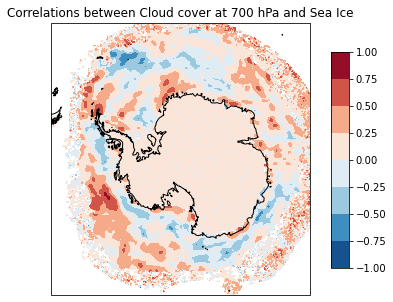

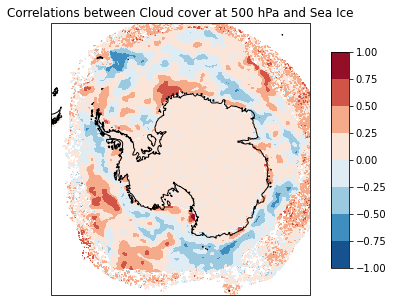

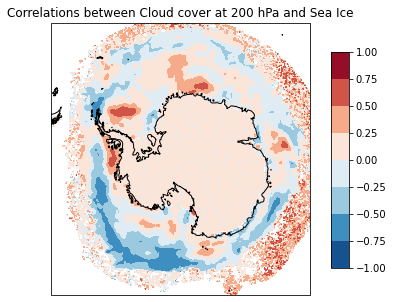

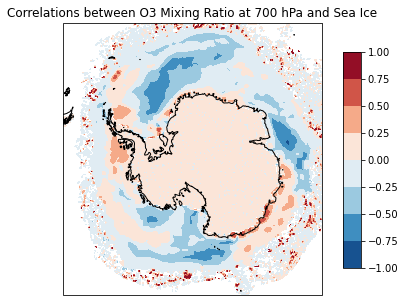

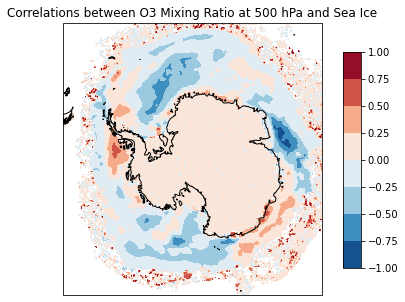

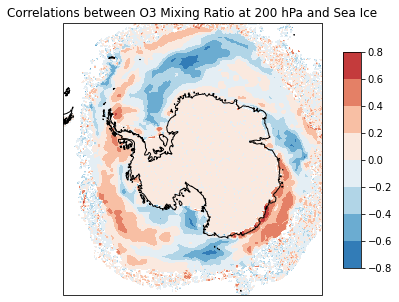

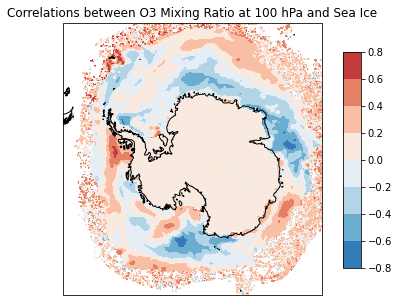

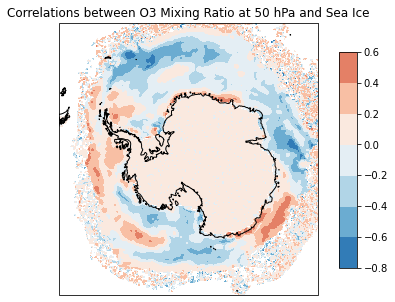

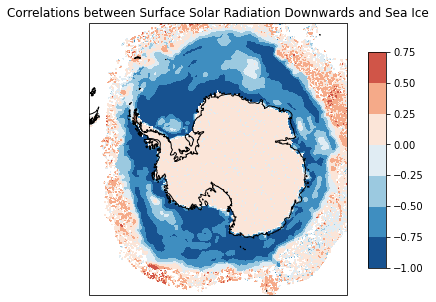

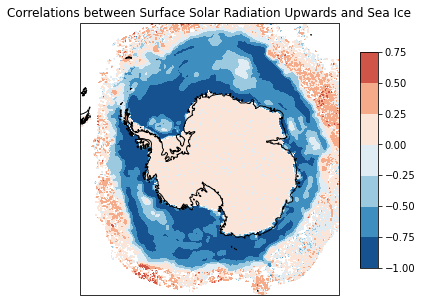

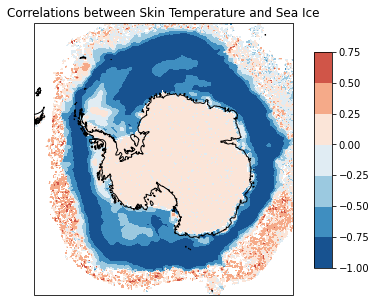

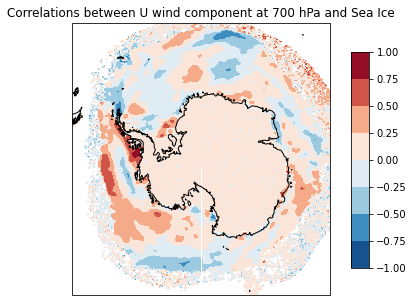

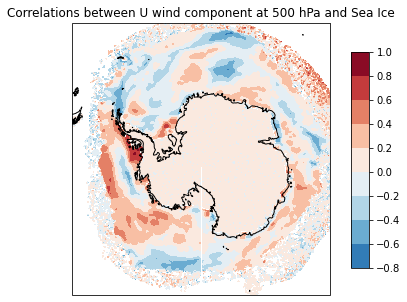

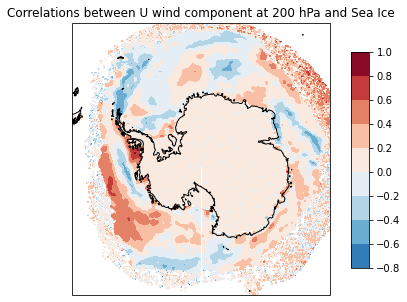

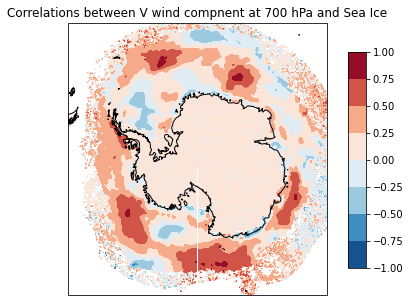

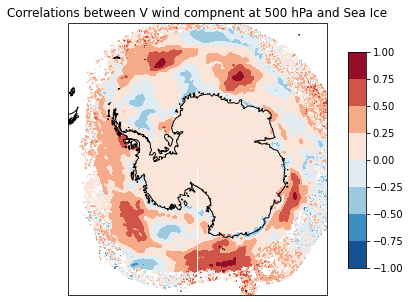

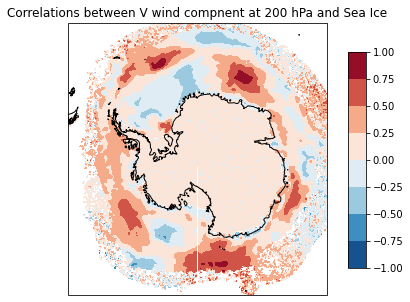

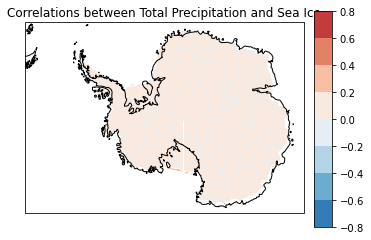

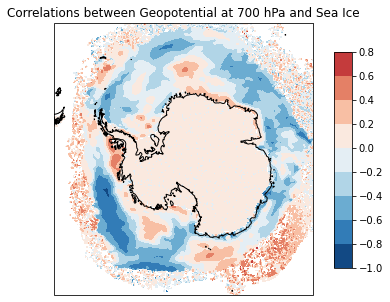

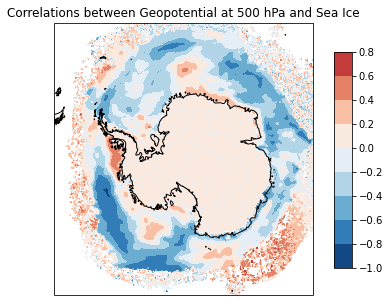

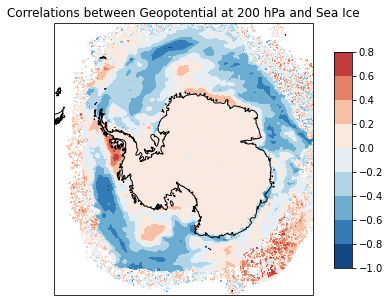

In [11]:
for variable in variables:
    data_spatial = correlations_dict[variable]
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
    vmax = max(-data_spatial.min(),data_spatial.max())
    vmin = -vmax
    divnorm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    contour = plt.contourf(data_spatial.x, data_spatial.y, data_spatial.values, norm = divnorm, transform = ccrs.SouthPolarStereo(), cmap='RdBu_r')
    ax.coastlines()
    ax.set_title(f'Correlations between {namedict[variable]} and Sea Ice')
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.93, 0.2, 0.05, 0.6])
    cbar = fig.colorbar(contour, cax=cbar_ax, shrink=0.88)
    misc.savefigures(folder='images/2021w4/correlation_sic', filename=f'{variable}')

# time series

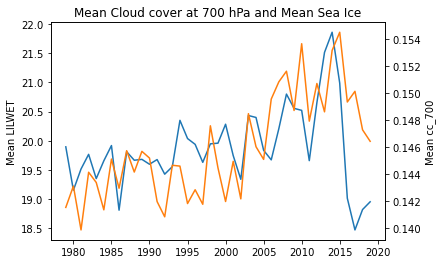

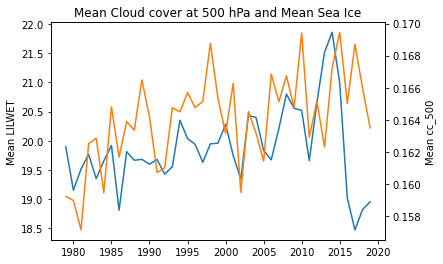

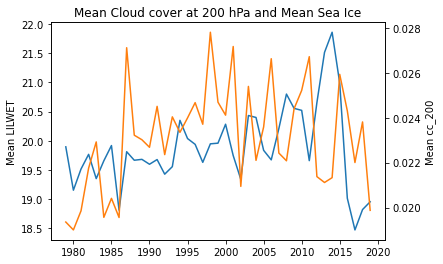

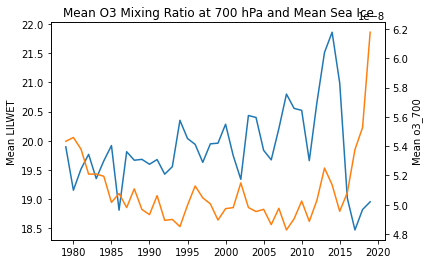

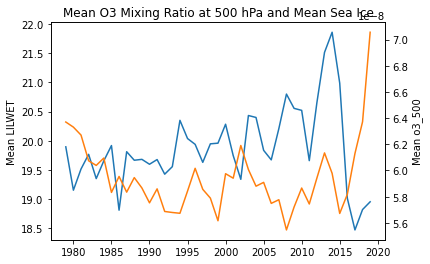

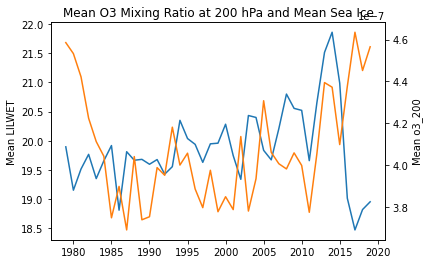

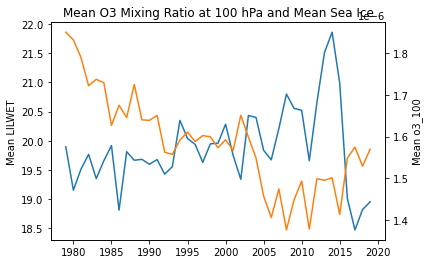

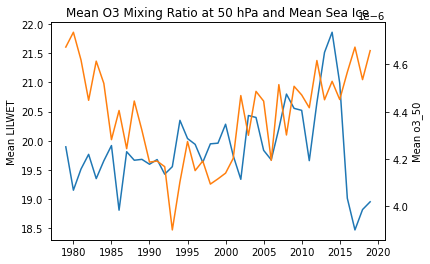

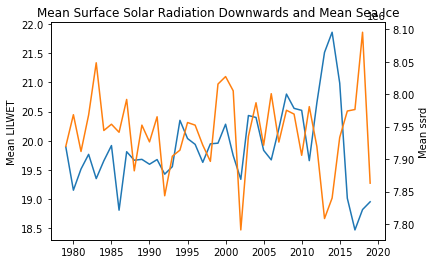

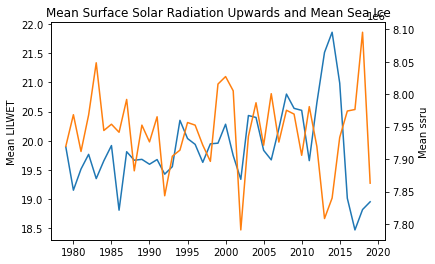

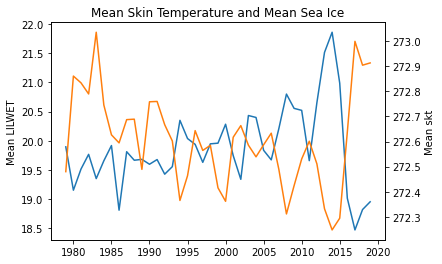

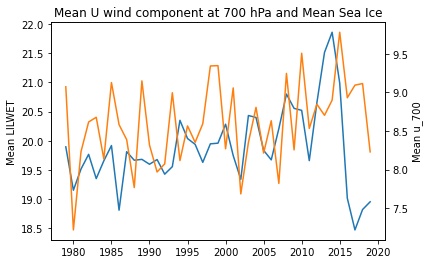

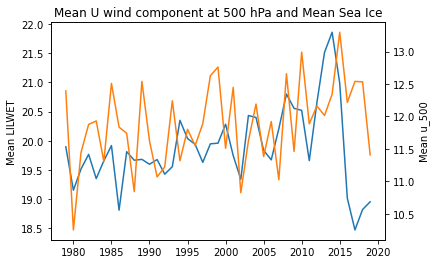

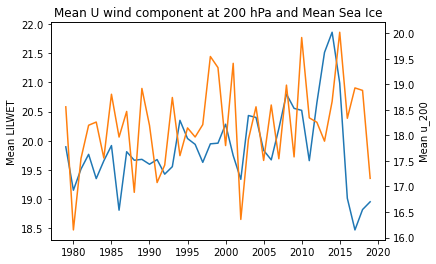

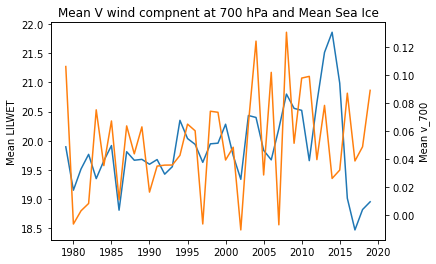

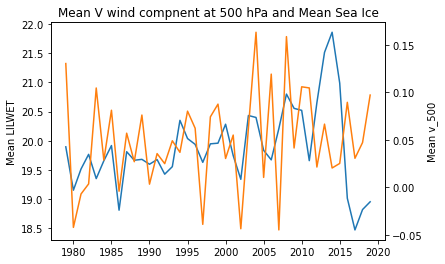

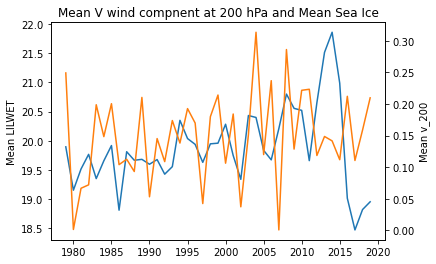

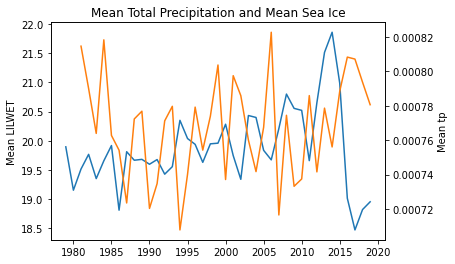

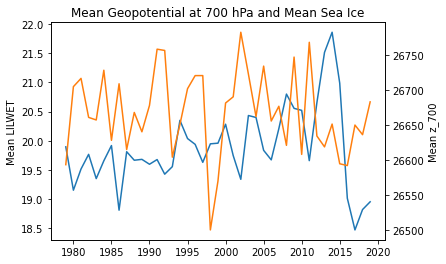

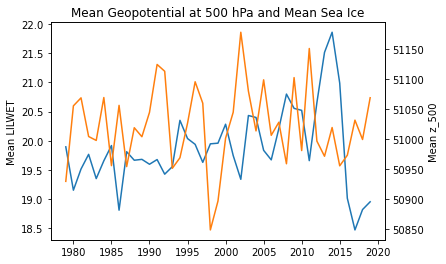

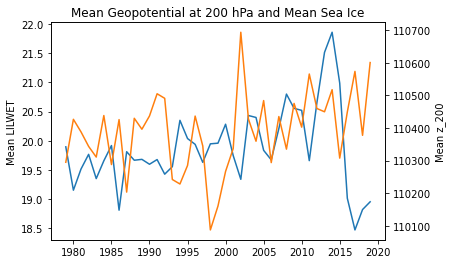

In [12]:
subdata = data_annually_averaged.where(~landmask)
for variable in variables:
    LIC_timeseries = subdata.SIC.mean(dim=('x','y'))
    variable_timeseries = subdata[variable].mean(dim=('x','y'))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    ax2 = ax1.twinx()
    ax1.plot(LIC_timeseries.time,LIC_timeseries.values)
    ax1.set_ylabel('Mean LILWET')
    
    ax2.plot([],[])
    ax2.plot(variable_timeseries.time,variable_timeseries.values)
    ax2.set_ylabel(f'Mean {variable}')
    
    ax1.set_title(f'Mean {namedict[variable]} and Mean Sea Ice')
    misc.savefigures(folder='images/2021w4/timeseries_sic', filename=f'{variable}')
    plt.show()

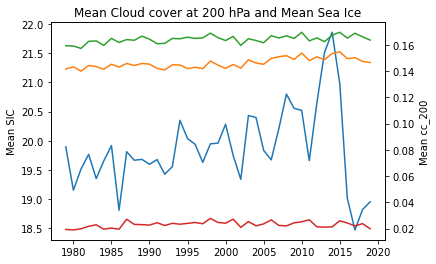

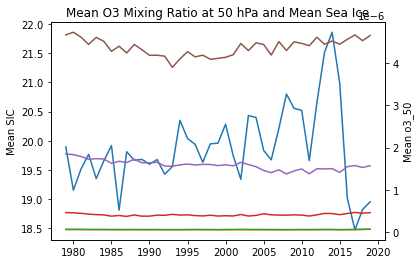

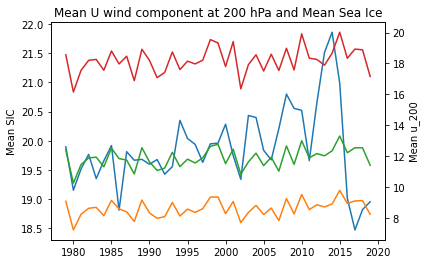

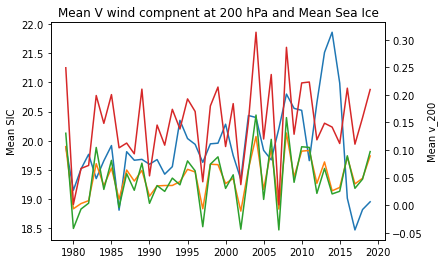

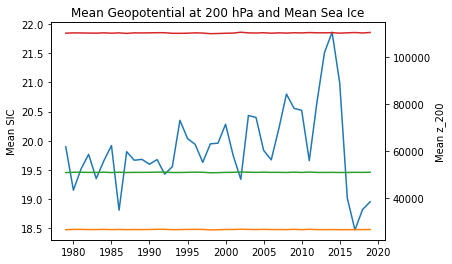

In [13]:
# subdata = data_annually_averaged.sel(time=slice('2002-01-01', '2019-12-31')).where(landmask)
variablessets = [
                    ['cc_700','cc_500','cc_200'],
                    ['o3_700','o3_500','o3_200', 'o3_100', 'o3_50'],
                    ['u_700','u_500','u_200'],
                    ['v_700','v_500','v_200'],
                    ['z_700','z_500','z_200'],
                ]
for variableset in variablessets:
    SIC_timeseries = subdata.SIC.mean(dim=('x','y'))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    ax2 = ax1.twinx()
    ax1.plot(LIC_timeseries.time,SIC_timeseries.values, label = 'SIC')
    ax1.set_ylabel('Mean SIC')
    
    ax2.plot([],[])
    for variable in variableset:
        variable_timeseries = subdata[variable].mean(dim=('x','y'))
        ax2.plot(variable_timeseries.time,variable_timeseries.values, label = namedict[variable])
    ax2.set_ylabel(f'Mean {variable}')
    
    ax1.set_title(f'Mean {namedict[variable]} and Mean Sea Ice')
    misc.savefigures(folder='images/2021w4/multitimeseries_sic', filename=f'{variable}')
    plt.show()

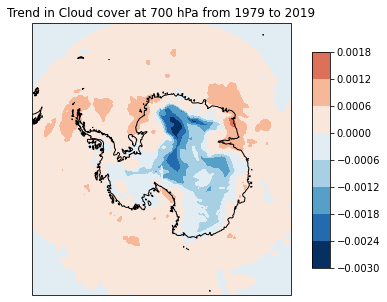

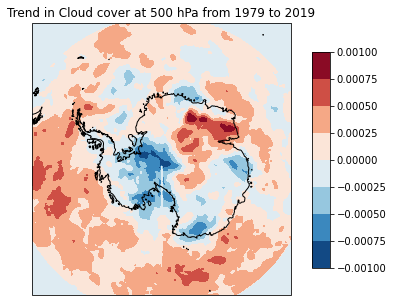

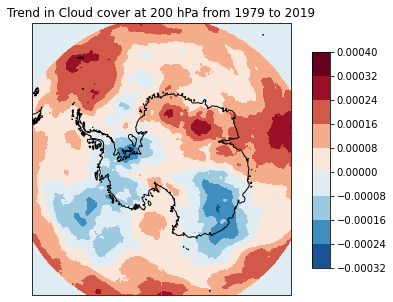

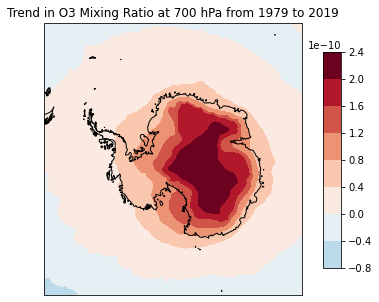

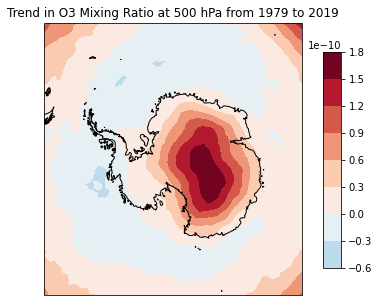

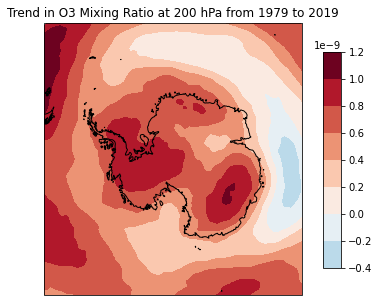

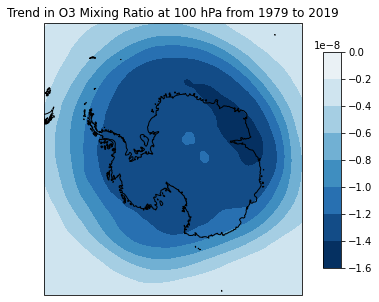

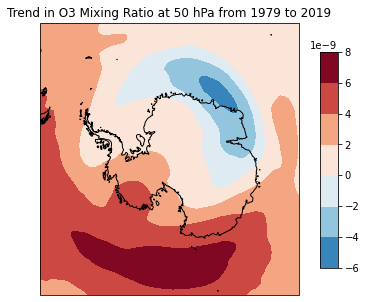

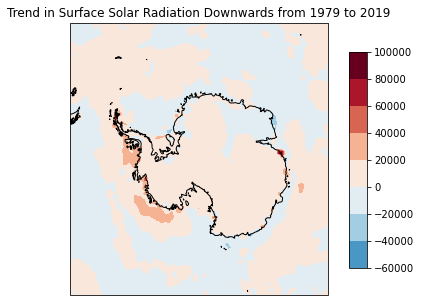

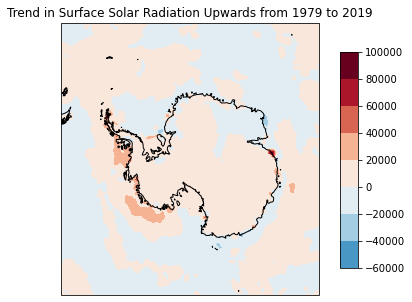

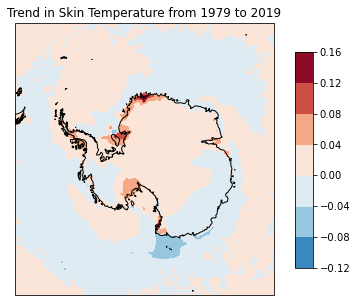

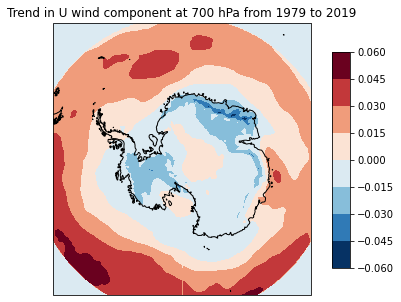

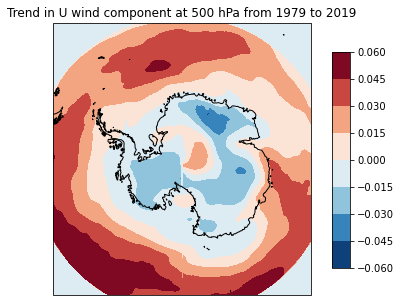

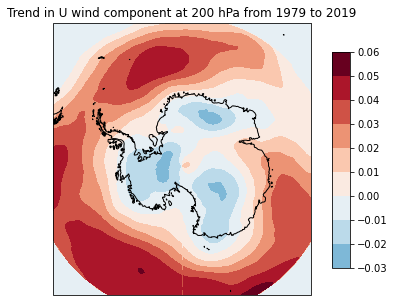

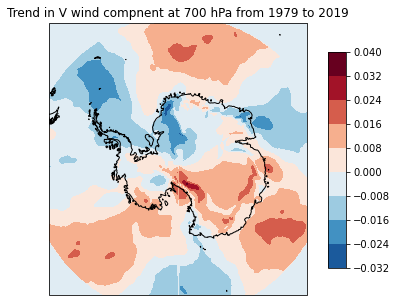

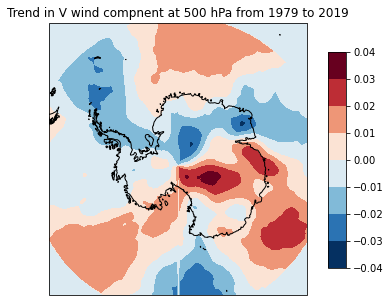

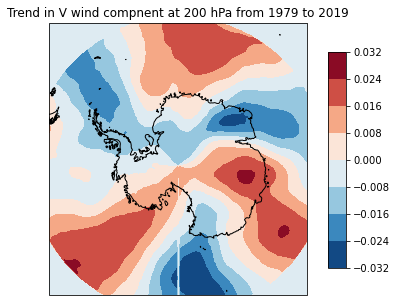

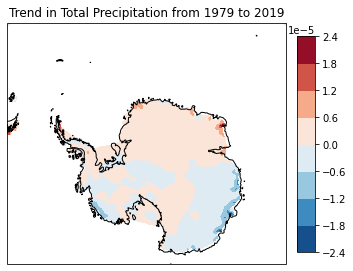

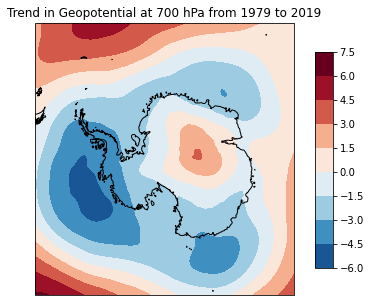

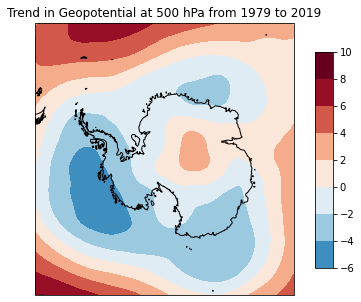

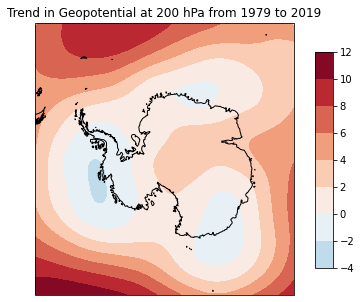

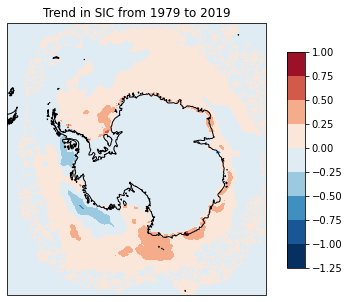

In [14]:
# subdata = data_annually_averaged.sel(time=slice('2002-01-01', '2019-12-31'))
for variable in variables+['SIC']:
    variable_trends = data[variable].polyfit(
        dim='time', deg=1).sel(degree=1).polyfit_coefficients * 1e9*60*60*24*365
    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
    
    vmax = max(-variable_trends.min(),variable_trends.max())
    vmin = -vmax
    divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    
    contour = ax1.contourf(variable_trends.x, variable_trends.y, variable_trends.values, norm=divnorm, transform = ccrs.SouthPolarStereo(), cmap='RdBu_r')
    ax1.coastlines()
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.93, 0.2, 0.05, 0.6])
    cbar = fig.colorbar(contour, cax=cbar_ax, shrink=0.8)
    ax1.set_title(f'Trend in {namedict[variable]} from 1979 to 2019')
    misc.savefigures(folder='images/2021w4/trends', filename=f'{variable}')

# Let's select the region of greatest decrease and see what impacts it

In [15]:
# LIC_mean = subdata.LIC.mean(dim=('time'))
# mask2 = LIC_mean<np.nanpercentile(LIC_mean, 5)
# mask2 *= LIC_mean.x <0
# np.nanpercentile(LIC_mean, 5)

# LIC_mean2 = LIC_mean.where(mask2)
# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
# plot = ax.contourf(LIC_mean2.x, LIC_mean2.y, LIC_mean2,
#                    levels=20, crs=ccrs.SouthPolarStereo())
# ax.coastlines()
# ax.set_title('Mean Land Ice LIELWT')
# cbar = plt.colorbar(plot)
# cbar.set_label(r'Mean Land Ice LIELWT [cm]')
# misc.savefigures(folder='images/2021w3', filename='decreasing_mean_lic_distribution')
# plt.show()

In [16]:
# LIC_peninsular_decrease = LIC.where(mask2)
# LIC_peninsular_decrease_timeseries = LIC_peninsular_decrease.mean(dim=('x','y'))
# LIC_peninsular_decrease_timeseries.plot()
# plt.title('Mean LIELWT over the decreasing region of the Antarctic Peninsula')
# plt.ylabel('Mean LIELWT [cm]')
# plt.axhline(0,color='k', alpha = 0.5)
# misc.savefigures(folder='images/2021w3', filename='decreasing_mean_lic_timeseries')
# plt.show()

In [17]:
# regressions = {}
# for variable in variables:
#     print(variable)
#     dependant = LIC_peninsular_decrease_timeseries
#     independant = subdata[variable].copy()
#     dependant, independant = xr.broadcast(dependant, independant)
#     ds = xr.Dataset(dict(dependant=dependant, independant=independant))
#     regression_results = w9.fast_single_regression(dependant, independant)
#     regressions[variable] = regression_results

In [18]:
# sig_threshold = 0.1
# for sig_threshold, variable in itertools.product([1, 0.1, 0.05], variables):
#     regression_results_sig = regressions[variable].where(regressions[variable].pvalues<=sig_threshold)

#     fig = plt.figure(figsize=(5, 5))
#     ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

#     divnorm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

#     plot = ax.contourf(regression_results_sig.x, regression_results_sig.y, regression_results_sig.correlation,
#                        levels=20, crs=ccrs.SouthPolarStereo(), norm = divnorm, cmap = 'RdBu_r')
#     ax.coastlines()
#     ax.set_title(f'Correlation of {namedict[variable]}\n with decreasing LIC [p$\leq${sig_threshold:.2f}]')
#     cbar = plt.colorbar(plot, shrink=0.8)
#     cbar.set_label(r'Correlation Coefficient')
#     misc.savefigures(folder='images/2021w3', filename=f'decreasing_region_correlations_{variable}_{sig_threshold}')
#     plt.show()

# #     fig = plt.figure(figsize=(5, 5))
# #     ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

# #     vmin, vmax = (-1000,1000)
# #     divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# #     plot = ax.contourf(regression_results_sig.x, regression_results_sig.y, regression_results_sig.regression,
# #                        levels=np.arange(vmin,vmax,100), crs=ccrs.SouthPolarStereo(), norm = divnorm, cmap = 'RdBu_r')
# #     ax.coastlines()
# #     ax.set_title(f'Regression of {namedict[variable]} with LILWET [p$\leq${sig_threshold:.2f}]')
# #     cbar = plt.colorbar(plot, shrink=0.8)
# #     cbar.set_label(r'Regression Coefficient [cm K$^{-1}$]')
# # #     misc.savefigures(folder='images/week10', filename=f'regressions_{sig_threshold}')
# #     plt.show()

# Greatest increase

In [19]:
# LIC_mean = subdata.LIC.mean(dim=('time'))
# mask2 = LIC_mean>np.nanpercentile(LIC_mean, 90)
# mask2 *= LIC_mean.x >0
# np.nanpercentile(LIC_mean, 5)

# LIC_mean2 = LIC_mean.where(mask2)
# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
# plot = ax.contourf(LIC_mean2.x, LIC_mean2.y, LIC_mean2,
#                    levels=20, crs=ccrs.SouthPolarStereo())
# ax.coastlines()
# ax.set_title('Mean Land Ice LIELWT')
# cbar = plt.colorbar(plot)
# cbar.set_label(r'Mean Land Ice LIELWT [cm]')
# misc.savefigures(folder='images/2021w3', filename='increasing_mean_lic_distribution')
# plt.show()

In [20]:
# LIC_peninsular_increase = LIC.where(mask2)
# LIC_peninsular_increase_timeseries = LIC_peninsular_increase.mean(dim=('x','y'))
# LIC_peninsular_increase_timeseries.plot()
# plt.title('Mean LIELWT over the increasing region of the Antarctic Peninsula')
# plt.ylabel('Mean LIELWT [cm]')
# plt.axhline(0,color='k', alpha = 0.5)
# misc.savefigures(folder='images/2021w3', filename='increasing_mean_lic_timeseries')
# plt.show()

In [21]:
regressions = {}
for variable in variables:
    print(variable)
    dependant = subdata['SIC'].copy()
    independant = subdata[variable].copy()
    dependant, independant = xr.broadcast(dependant, independant)
    ds = xr.Dataset(dict(dependant=dependant, independant=independant))
    regression_results = w9.fast_single_regression(dependant, independant)
    regressions[variable] = regression_results

cc_700
Running regression for SIC from cc_700
Regression finished
cc_500
Running regression for SIC from cc_500
Regression finished
cc_200
Running regression for SIC from cc_200
Regression finished
o3_700
Running regression for SIC from o3_700
Regression finished
o3_500
Running regression for SIC from o3_500
Regression finished
o3_200
Running regression for SIC from o3_200
Regression finished
o3_100
Running regression for SIC from o3_100
Regression finished
o3_50
Running regression for SIC from o3_50
Regression finished
ssrd
Running regression for SIC from ssrd
Regression finished
ssru
Running regression for SIC from ssru
Regression finished
skt
Running regression for SIC from skt
Regression finished
u_700
Running regression for SIC from u_700
Regression finished
u_500
Running regression for SIC from u_500
Regression finished
u_200
Running regression for SIC from u_200
Regression finished
v_700
Running regression for SIC from v_700
Regression finished
v_500
Running regression for SIC f

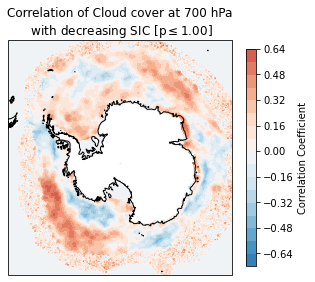

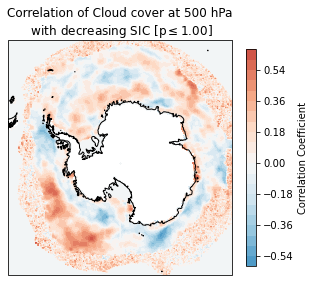

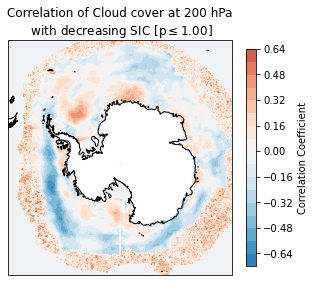

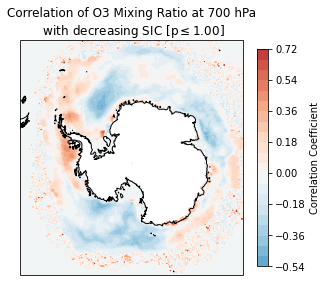

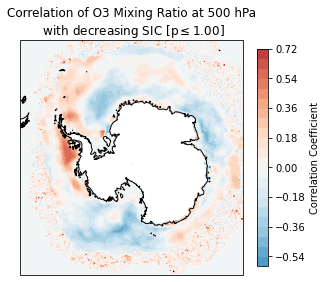

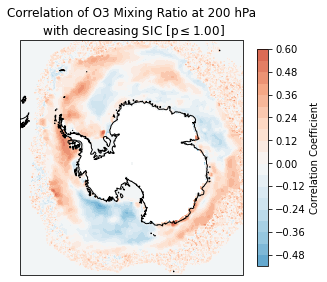

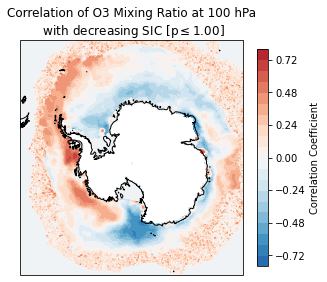

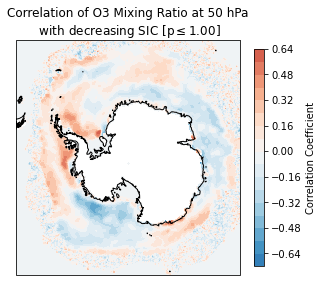

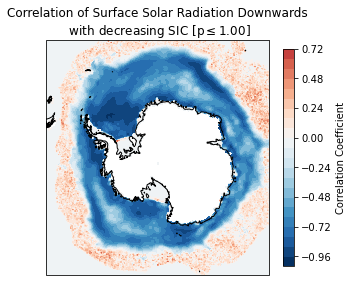

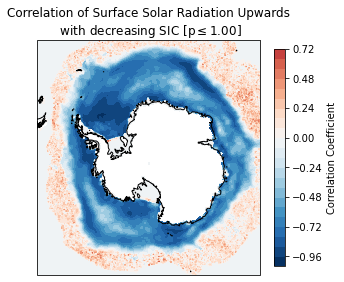

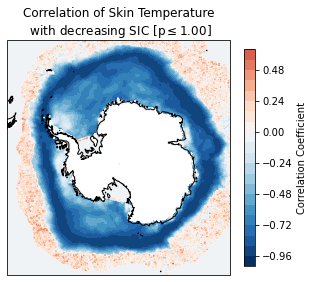

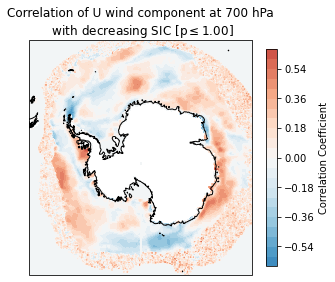

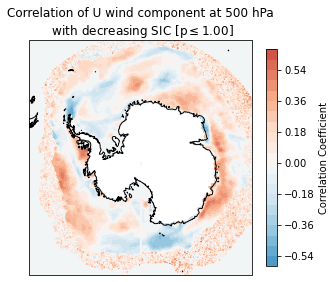

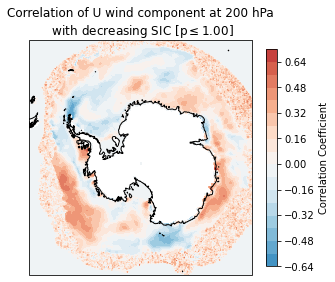

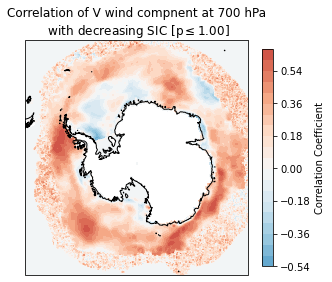

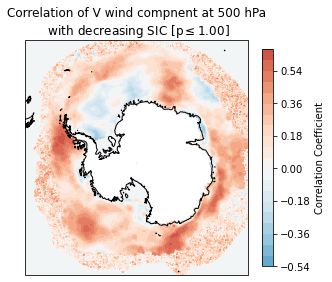

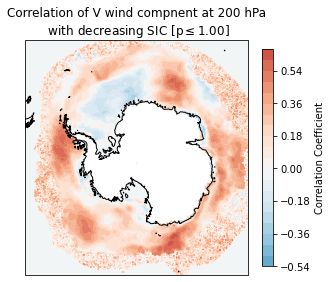

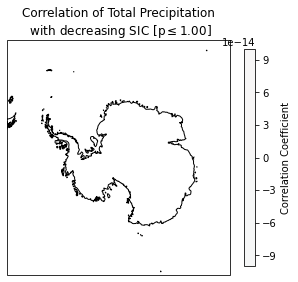

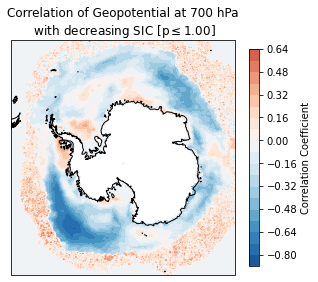

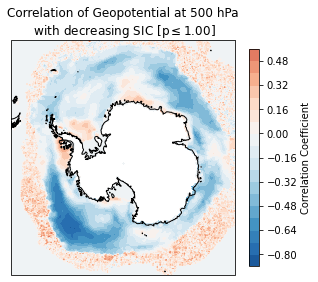

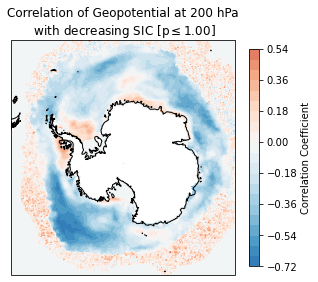

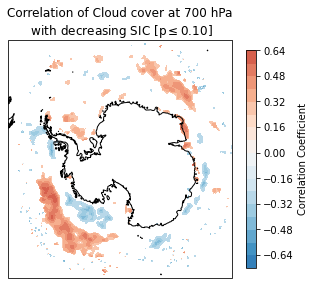

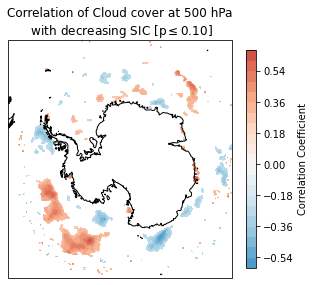

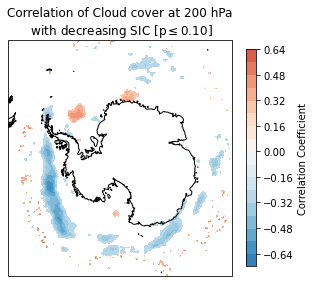

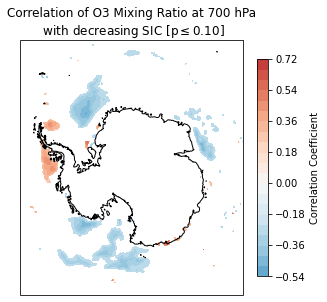

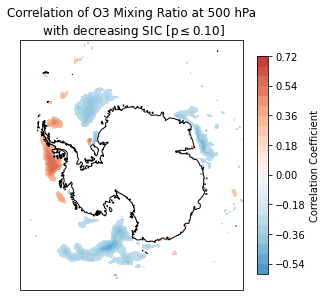

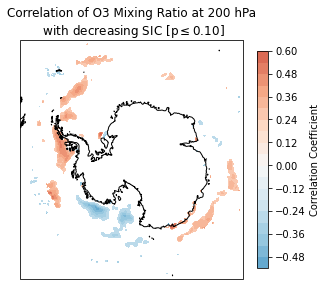

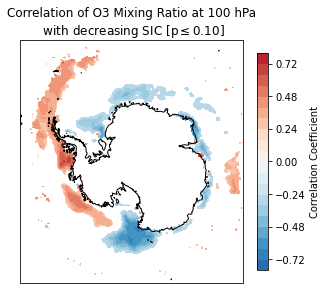

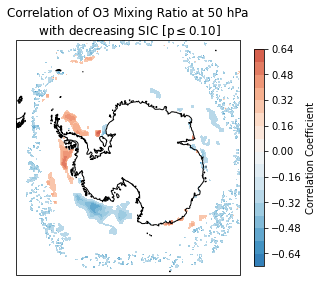

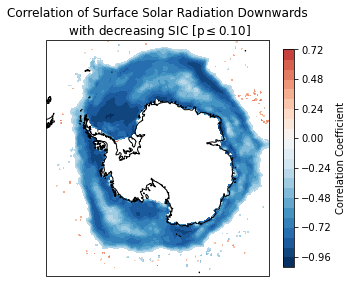

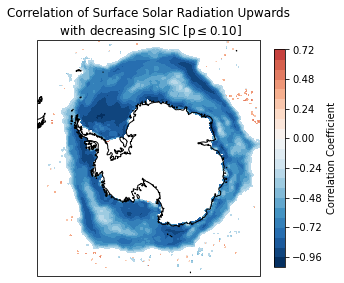

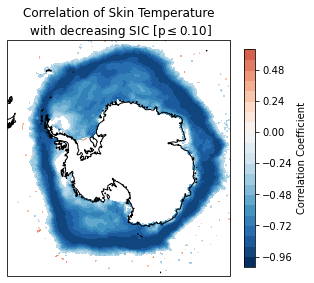

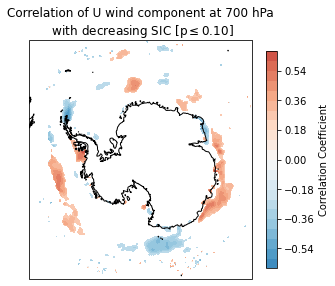

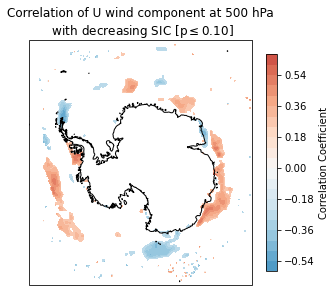

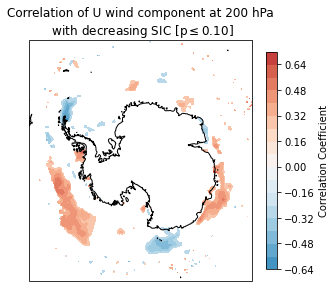

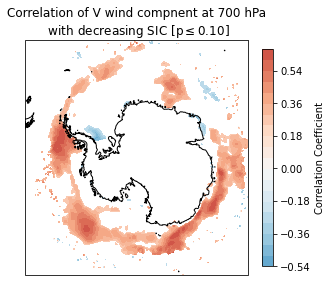

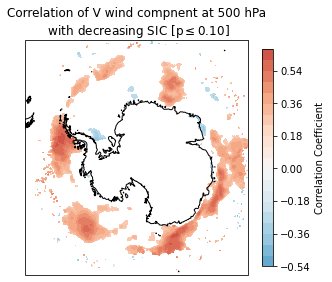

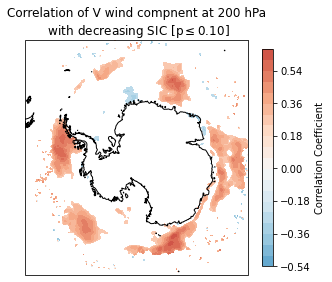

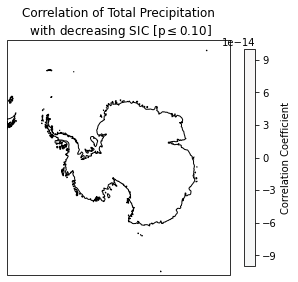

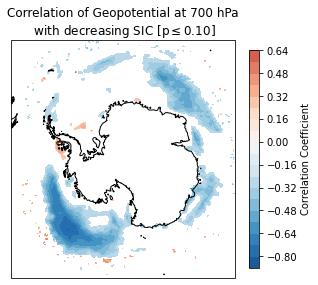

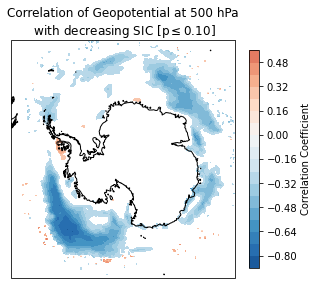

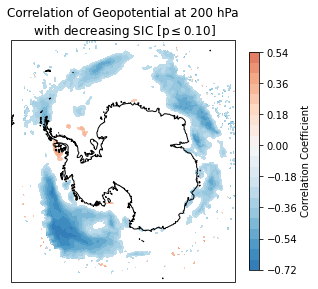

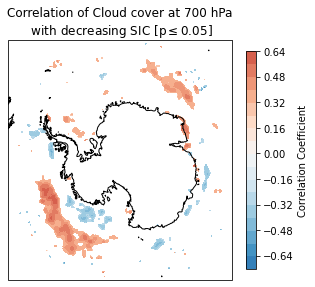

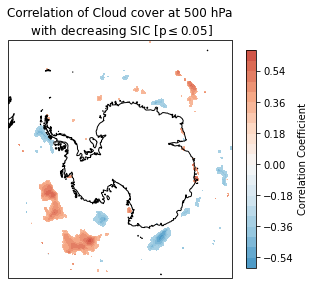

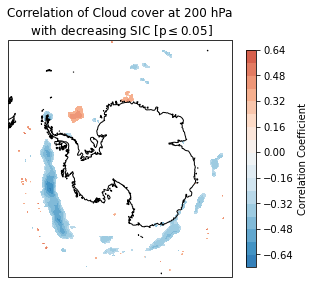

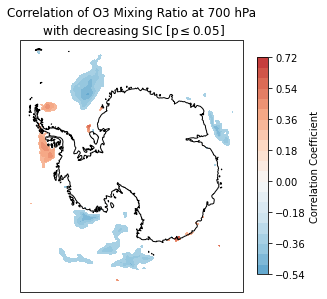

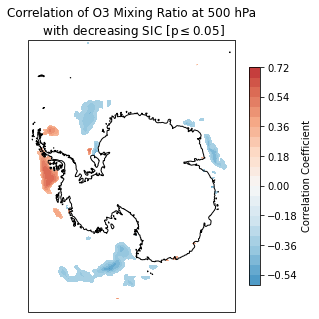

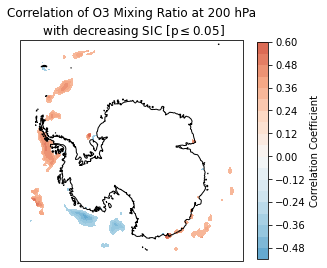

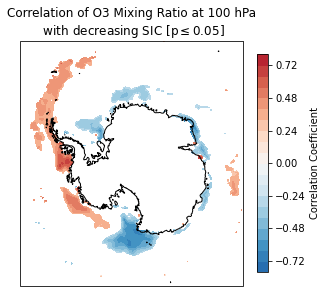

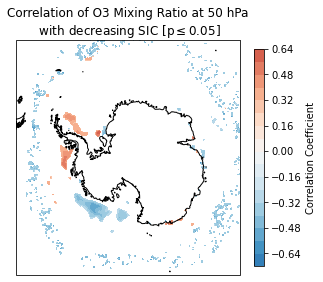

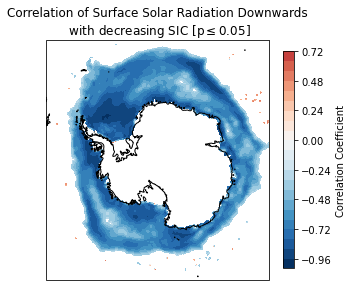

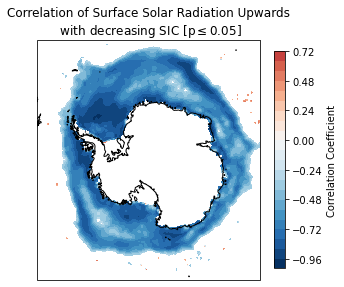

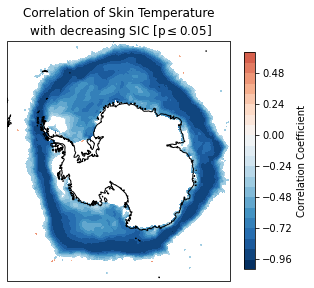

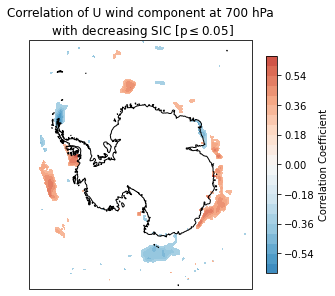

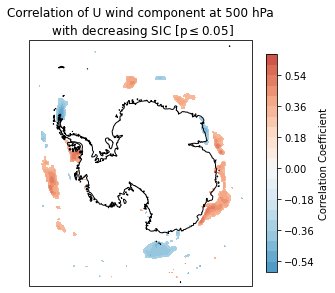

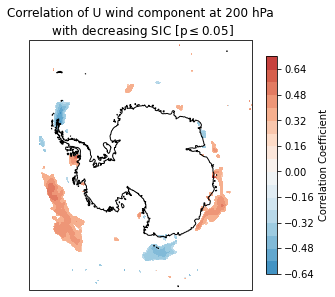

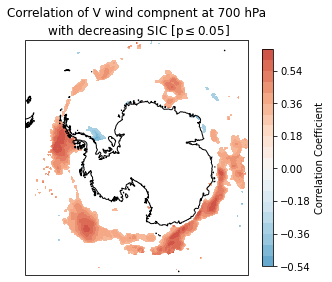

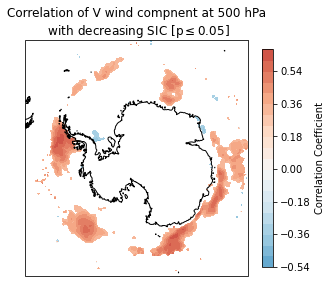

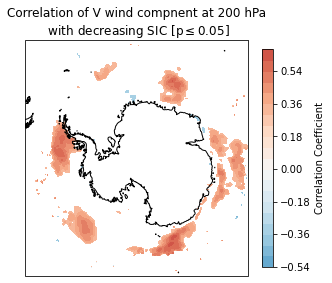

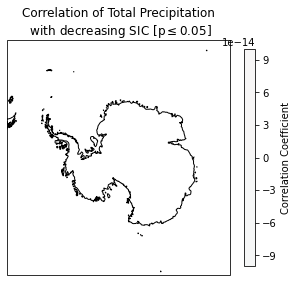

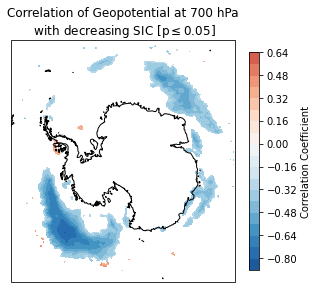

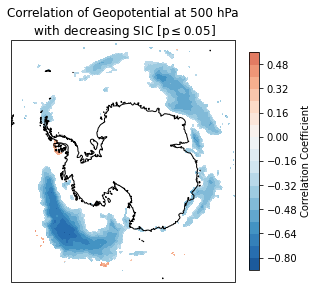

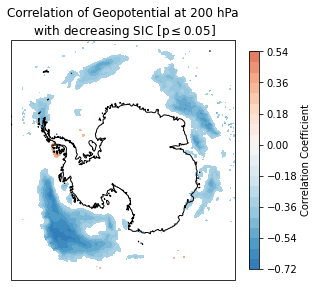

In [22]:
sig_threshold = 0.1
for sig_threshold, variable in itertools.product([1, 0.1, 0.05], variables):
    regression_results_sig = regressions[variable].where(regressions[variable].pvalues<=sig_threshold)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

    divnorm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

    plot = ax.contourf(regression_results_sig.x, regression_results_sig.y, regression_results_sig.correlation,
                       levels=20, crs=ccrs.SouthPolarStereo(), norm = divnorm, cmap = 'RdBu_r')
    ax.coastlines()
    ax.set_title(f'Correlation of {namedict[variable]}\n with decreasing SIC [p$\leq${sig_threshold:.2f}]')
    cbar = plt.colorbar(plot, shrink=0.8)
    cbar.set_label(r'Correlation Coefficient')
    misc.savefigures(folder='images/2021w4/significant_correlations_sic', filename=f'{variable}_{sig_threshold}')
    plt.show()